In [1]:
import gym

import torch
import torch.nn as nn

import time
from tqdm.notebook import tqdm
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline

# Deep Q-learning

In [87]:
class NN(nn.Module):
    def __init__(self, state_dim, action_n):
        super(NN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, action_n))

    def forward(self, x):
        x = torch.FloatTensor(x)
        return self.net(x)


class DQN():
    def __init__(self, model, action_n, batch_size, trajectory_n):
        self.model = model
        self.action_n = action_n
        self.epsilon = 1
        self.epsilon_decrease = 1 / trajectory_n
        self.memory = []
        self.batch_size = batch_size


    def get_action(self, state):

        qvalues = self.model(state).detach().numpy()
        probs = np.ones(self.action_n) * self.epsilon / self.action_n
        agrmax_action = np.argmax(qvalues)
        probs[agrmax_action] += 1 - self.epsilon
        action = np.random.choice(self.action_n, p=probs)

        return action

    def get_batch(self):
        batch = sample(population=self.memory, k=self.batch_size)

        states, actions, rewards, dones, next_states = [], [], [], [], []

        for i in range(self.batch_size):
            states.append(batch[i][0])
            actions.append(batch[i][1])
            rewards.append(batch[i][2])
            dones.append(batch[i][3])
            next_states.append(batch[i][4])

        return states, actions, rewards, dones, next_states


    def training_step(self, state, action, reward, done, next_state, gamma):
        
        self.memory.append([state, action, reward, done, next_state])


        if len(self.memory) > self.batch_size * 10:
            
            states, actions, rewards, dones, next_states = self.get_batch()



            q = self.model(states)
            q_next = self.model(next_states)

            targets = q.clone()

            for i in range(self.batch_size):
                targets[i][actions[i]] = rewards[i] + (1 - dones[i]) * gamma * torch.max(q_next[i])

            loss = torch.mean((targets.detach() - q) ** 2)
            self.epsilon = max(0, self.epsilon - self.epsilon_decrease)
            return loss


In [105]:
def train_dqn(traj_n, agent, model, env, trajectory_len, gamma_start, gamma_end, lr, opt_f=torch.optim.SGD):


    opt = opt_f(model.parameters(), lr=lr)
    history = {'rewards': [], 'losses': []}
    
    slope = (gamma_end - gamma_start) / n
    gamma_sched = lambda traj_i: traj_i * slope + gamma_start
    
    for traj_i in tqdm(range(traj_n)):
        
        
        trajectory_reward = 0
        trajectory_loss = 0
        
        if traj_i <= traj_n * 0.2:
            gamma = gamma_start
        else:
            gamma = gamma_sched(traj_i)
        
        state = env.reset()
        
        for _ in range(trajectory_len):

            action = agent.get_action(state)

            next_state, reward, done, _ = env.step(action)

            trajectory_reward += reward
            loss = agent.training_step(state, action, reward, done, next_state, gamma)

            if loss is not None:
                loss.backward()
                opt.step()
                opt.zero_grad()
                trajectory_loss += loss.item()
            state = next_state

            if done:
                break
        
        history['rewards'].append(trajectory_reward)
        history['losses'].append(trajectory_loss)
        if traj_i % 10 == 0:
            print(f'{traj_i = } \t {trajectory_reward = } \t {trajectory_loss = }')

    return history

# Deep Cross-Entropy

In [4]:
class CEMAgent(nn.Module):
    def __init__(self, state_dim, action_n, loss_f=nn.CrossEntropyLoss()):
        super(CEMAgent, self).__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        self.net = nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_n),
            nn.Softmax(dim=0))
        self.loss_f = loss_f

    def forward(self, x):
        return self.net(x)

    def get_action(self, state):
        state = torch.FloatTensor(state)
        action_probs = self(state)
        action = np.random.choice(self.action_n, p=action_probs.detach().numpy())
        return action

    def training_step(self, elite_trajectories):
        elite_states, elite_actions = [], []
        for t in elite_trajectories:
            elite_states.extend(t['states'])
            elite_actions.extend(t['actions'])
        elite_states = torch.FloatTensor(np.array(elite_states))
        elite_actions = torch.LongTensor(np.array(elite_actions))
        out = self(elite_states)
        loss = self.loss_f(out, elite_actions)
        return loss * 10000

In [5]:
def get_trajectory(env, agent, trajectory_len, viz=False):
    trajectory = {
        'states': [],
        'actions': [],
        'reward': 0
    }
    state = env.reset()
    trajectory['states'].append(state)
    for _ in range(trajectory_len):
        action = agent.get_action(state)
        state, reward, done, _ = env.step(action)
        trajectory['actions'].append(action)
        trajectory['reward'] += reward
        if viz:
            env.render()
        if done:
            break
        trajectory['states'].append(state)
    return trajectory


def get_elite_trajectories(trajectories, q_param):
    rewards = [t['reward'] for t in trajectories]
    q_value = np.quantile(rewards, q_param)
    return round(np.mean(rewards), 2), [t for t in trajectories if t['reward'] > q_value]

In [14]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group["lr"]



def train_dce(epochs, env, agent, traj_per_epoch, lr, trajectory_len=500, opt_f=torch.optim.SGD):
    history = {'loss': [], 'reward': [], 'q_param': [], 'lr': [], 'etn': []}
    
    opt = opt_f(agent.parameters(), lr=lr)
    
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, epochs=epochs, steps_per_epoch=1)
    q_sched = lambda epoch: max(0.7, (epoch / epochs)*0.9)

    start = time.perf_counter()
    loss = 0
    
    for epoch in range(epochs):
        trajectories = [get_trajectory(env, agent, trajectory_len) for _ in tqdm(range(traj_per_epoch), leave=True, colour='blue')]
        el_tr_n = 0
        loss = 0
        q_param = round(q_sched(epoch), 5)
        mean_reward, elite_trajectories = get_elite_trajectories(trajectories, q_param)
        
        if len(elite_trajectories) > 0:
            el_tr_n = len(elite_trajectories)
            loss = agent.training_step(elite_trajectories)
            loss.backward()
            opt.step()
            opt.zero_grad()
            loss = round(loss.item(), 2)
        last_lr = round(get_lr(opt), 5)
        history['loss'].append(loss)
        history['reward'].append(mean_reward)
        history['q_param'].append(q_param)
        history['lr'].append(last_lr)
        history['etn'].append(el_tr_n)

        print(f'Epoch [{epoch}] Mean reward [{mean_reward}] Loss [{round(loss, 2)}] Q param [{round(q_param, 3)}] Last lr[{round(last_lr, 4)}] Elite traj n [{el_tr_n}]')
        lr_scheduler.step()
    end = time.perf_counter()
    print(f'Training took {round(end-start, 4)} secs')
    return history


In [106]:
env = gym.make("Acrobot-v1")

trajectory_len = 500
state_dim = env.observation_space.shape[0]
action_n = env.action_space.n
batch_size = 64
gamma = 0.995
lr = 1e-2
opt_f = torch.optim.Adam

traj_n = 200

/home/verius00/.local/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/verius00/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [107]:
model_dqn = NN(state_dim=state_dim, action_n=action_n)
agent_dqn = DQN(model=model_dqn, action_n=action_n, batch_size=batch_size, trajectory_n=traj_n)

In [108]:
gamma_start = 0.99
gamma_end = 0.9999
history_dqn_sched = train_dqn(traj_n, agent_dqn, model_dqn, env, trajectory_len, gamma_start, gamma_end, lr, opt_f=opt_f)

  0%|          | 0/200 [00:00<?, ?it/s]

traj_i = 0 	 trajectory_reward = -500.0 	 trajectory_loss = 0
traj_i = 10 	 trajectory_reward = -350.0 	 trajectory_loss = 900.8044129833579
traj_i = 20 	 trajectory_reward = -500.0 	 trajectory_loss = 1174.6323072910309
traj_i = 30 	 trajectory_reward = -335.0 	 trajectory_loss = 946.5728949606419
traj_i = 40 	 trajectory_reward = -223.0 	 trajectory_loss = 44011.90362513065
traj_i = 50 	 trajectory_reward = -172.0 	 trajectory_loss = 670.7551389336586
traj_i = 60 	 trajectory_reward = -142.0 	 trajectory_loss = 326.83369877934456
traj_i = 70 	 trajectory_reward = -144.0 	 trajectory_loss = 255.41963297128677
traj_i = 80 	 trajectory_reward = -164.0 	 trajectory_loss = 363.6972377002239
traj_i = 90 	 trajectory_reward = -170.0 	 trajectory_loss = 439.7108859717846
traj_i = 100 	 trajectory_reward = -102.0 	 trajectory_loss = 273.03349727392197
traj_i = 110 	 trajectory_reward = -103.0 	 trajectory_loss = 193.8150086402893
traj_i = 120 	 trajectory_reward = -364.0 	 trajectory_loss = 7

In [40]:
history_dqn_09 = history_dqn

In [ ]:
agent_dce = CEMAgent(state_dim, action_n)

In [20]:
epochs = 31
traj_per_epoch = 800
lr_dce = 0.3
opt_f = torch.optim.Adam
history_dce = train_dce(epochs, env, agent_dce, traj_per_epoch, lr_dce)

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [0] Mean reward [-499.66] Loss [10986.12] Q param [0.7] Last lr[0.012] Elite traj n [3]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [1] Mean reward [-499.73] Loss [10986.12] Q param [0.7] Last lr[0.0222] Elite traj n [6]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [2] Mean reward [-498.48] Loss [10986.12] Q param [0.7] Last lr[0.0513] Elite traj n [16]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [3] Mean reward [-495.2] Loss [10986.12] Q param [0.7] Last lr[0.0953] Elite traj n [51]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [4] Mean reward [-477.44] Loss [10986.12] Q param [0.7] Last lr[0.1478] Elite traj n [194]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [5] Mean reward [-427.31] Loss [10986.12] Q param [0.7] Last lr[0.2015] Elite traj n [239]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [6] Mean reward [-351.7] Loss [10986.12] Q param [0.7] Last lr[0.2488] Elite traj n [235]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [7] Mean reward [-287.36] Loss [10986.1] Q param [0.7] Last lr[0.2829] Elite traj n [237]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [8] Mean reward [-234.91] Loss [10986.08] Q param [0.7] Last lr[0.2991] Elite traj n [236]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [9] Mean reward [-190.21] Loss [10986.04] Q param [0.7] Last lr[0.2992] Elite traj n [240]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [10] Mean reward [-148.59] Loss [10985.93] Q param [0.7] Last lr[0.2955] Elite traj n [232]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [11] Mean reward [-117.67] Loss [10985.71] Q param [0.7] Last lr[0.2887] Elite traj n [237]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [12] Mean reward [-96.59] Loss [10985.5] Q param [0.7] Last lr[0.279] Elite traj n [228]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [13] Mean reward [-87.45] Loss [10985.45] Q param [0.7] Last lr[0.2666] Elite traj n [224]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [14] Mean reward [-86.24] Loss [10985.49] Q param [0.7] Last lr[0.2518] Elite traj n [236]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [15] Mean reward [-86.13] Loss [10985.42] Q param [0.7] Last lr[0.2348] Elite traj n [201]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [16] Mean reward [-85.62] Loss [10985.5] Q param [0.7] Last lr[0.2161] Elite traj n [229]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [17] Mean reward [-84.14] Loss [10985.51] Q param [0.7] Last lr[0.1959] Elite traj n [229]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [18] Mean reward [-84.14] Loss [10985.43] Q param [0.7] Last lr[0.1749] Elite traj n [198]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [19] Mean reward [-84.95] Loss [10985.51] Q param [0.7] Last lr[0.1533] Elite traj n [201]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [20] Mean reward [-83.76] Loss [10985.46] Q param [0.7] Last lr[0.1316] Elite traj n [201]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [21] Mean reward [-83.74] Loss [10985.51] Q param [0.7] Last lr[0.1103] Elite traj n [222]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [22] Mean reward [-84.42] Loss [10985.54] Q param [0.7] Last lr[0.0898] Elite traj n [226]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [23] Mean reward [-86.68] Loss [10985.41] Q param [0.7] Last lr[0.0707] Elite traj n [194]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [24] Mean reward [-86.63] Loss [10985.51] Q param [0.7] Last lr[0.0531] Elite traj n [211]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [25] Mean reward [-84.48] Loss [10985.37] Q param [0.726] Last lr[0.0376] Elite traj n [183]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [26] Mean reward [-85.51] Loss [10985.45] Q param [0.755] Last lr[0.0245] Elite traj n [191]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [27] Mean reward [-85.31] Loss [10985.13] Q param [0.784] Last lr[0.0139] Elite traj n [153]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [28] Mean reward [-84.73] Loss [10985.07] Q param [0.813] Last lr[0.0063] Elite traj n [140]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [29] Mean reward [-85.78] Loss [10984.43] Q param [0.842] Last lr[0.0016] Elite traj n [90]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [30] Mean reward [-86.42] Loss [10984.48] Q param [0.871] Last lr[0.0] Elite traj n [93]
Training took 2276.977 secs


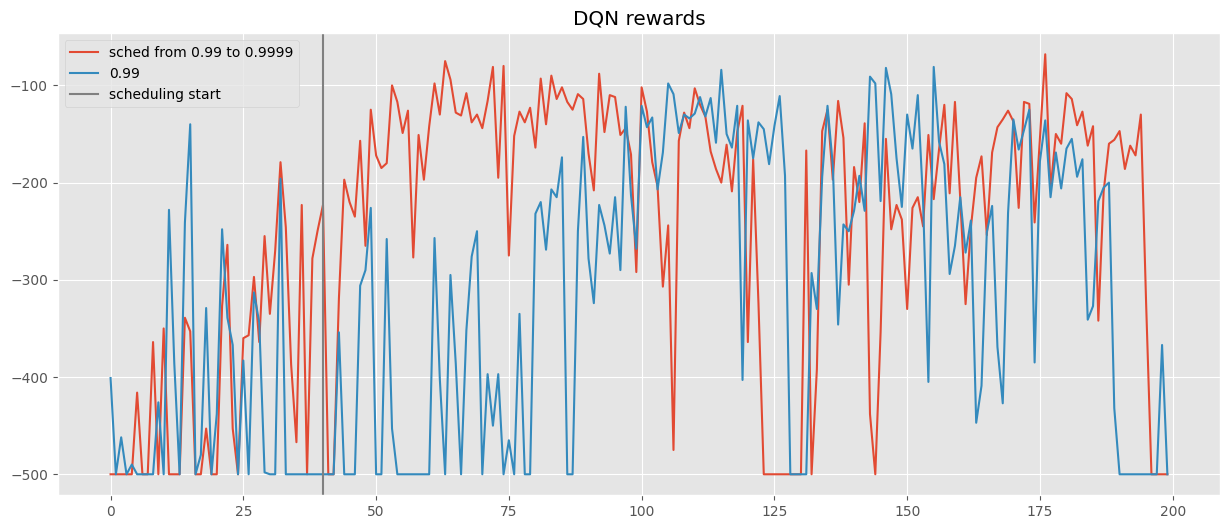

In [124]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(15, 6))
    plt.plot(history_dqn_sched['rewards'], label=f'sched from {gamma_start} to {gamma_end}')
    plt.plot(history_dqn_099['rewards'], label='0.99')
    plt.axvline(x=traj_n * 0.2, color='gray', label='scheduling start')
    plt.title('DQN rewards')
    plt.legend()
    plt.show()

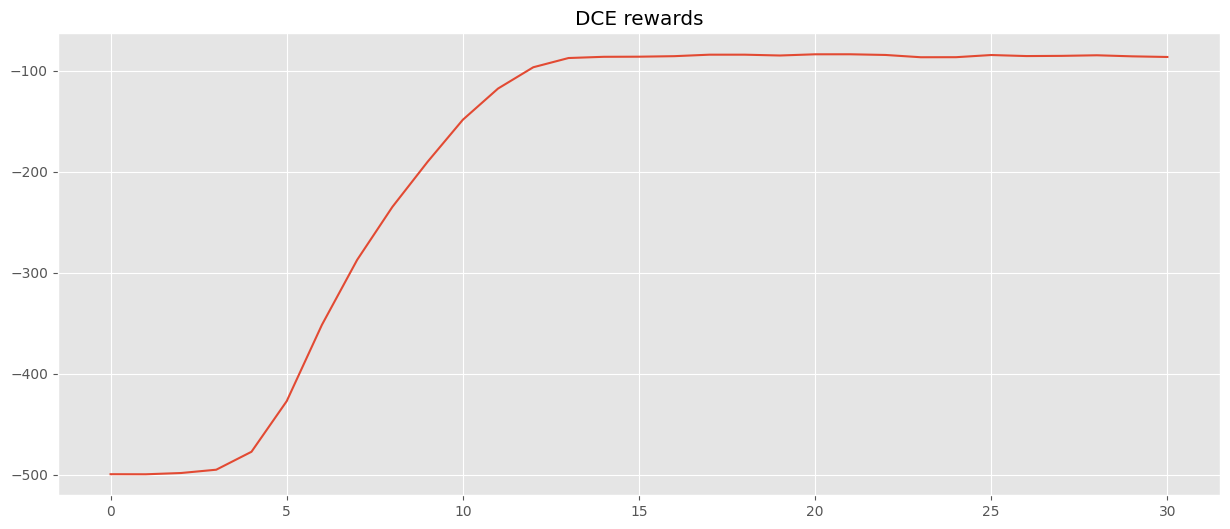

In [29]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(15, 6))
    plt.plot(history_dce['reward'])
    plt.title('DCE rewards')
    